## Import All Libraries For Image Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Get Folder Names

In [2]:
dataset_path = "./complete_ms_data/"
groundtruth_images = []
image_size = 512
patch_size = 64
stride = 32

# Get a list of subfolders in the dataset path
subfolders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])

print(subfolders)

['face_ms', 'fake_and_real_beers_ms', 'fake_and_real_food_ms', 'fake_and_real_lemon_slices_ms', 'fake_and_real_lemons_ms', 'fake_and_real_peppers_ms', 'fake_and_real_strawberries_ms', 'fake_and_real_sushi_ms', 'fake_and_real_tomatoes_ms', 'feathers_ms', 'flowers_ms', 'glass_tiles_ms', 'hairs_ms']


## Import All Images

In [3]:
# Iterate over each subfolder
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_path, subfolder)
    print(subfolder_path)

    # Stack all the individual images to form a hyperspectral image
    hyperspectral_image = np.empty((image_size, image_size, 31), dtype=np.uint8)
    i = 0
    for filename in sorted(os.listdir(subfolder_path)):
        if filename.endswith(".png"):
            image_file = filename
            image_path = os.path.join(subfolder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            hyperspectral_image[:, :, i] = image
            i = i + 1
            

    # Crop the hyperspectral image into smaller patches
    for y in range(0, image_size - patch_size + 1, stride):
        for x in range(0, image_size - patch_size + 1, stride):
            patch = hyperspectral_image[y:y+patch_size, x:x+patch_size, :]


            # Append the cropped patch to the groundtruth_images list
            groundtruth_images.append(patch)

# Convert the list of ground truth patches to a numpy array
groundtruth_arrays = np.array(groundtruth_images)

# Print the shape of the ground truth hyperspectral images array
print("Ground Truth Hyperspectral Images Shape:", groundtruth_arrays.shape)

./complete_ms_data/face_ms
./complete_ms_data/fake_and_real_beers_ms
./complete_ms_data/fake_and_real_food_ms
./complete_ms_data/fake_and_real_lemon_slices_ms
./complete_ms_data/fake_and_real_lemons_ms
./complete_ms_data/fake_and_real_peppers_ms
./complete_ms_data/fake_and_real_strawberries_ms
./complete_ms_data/fake_and_real_sushi_ms
./complete_ms_data/fake_and_real_tomatoes_ms
./complete_ms_data/feathers_ms
./complete_ms_data/flowers_ms
./complete_ms_data/glass_tiles_ms
./complete_ms_data/hairs_ms
Ground Truth Hyperspectral Images Shape: (2925, 64, 64, 31)


## Obtain A Low Resolution HSI Image of Shape (8,8,31)
One will simulate an image with low spatial dimensions and high spectral dimension. You'll obtain this by applying a 8,8 averaging filter on each band of your image of resolution 64,64,31 to obtain an image of resolution of 8,8,31. Let's call this one a low(spatial) resolution HSIimage.

In [ ]:
import numpy as np
from scipy.ndimage import uniform_filter

# Define the size of the averaging filter
filter_size = (8, 8)

# Apply the averaging filter on each band of the ground truth hyperspectral images
lowres_hsi_images = np.zeros((groundtruth_arrays.shape[0], 8, 8, 31))
for i in range(groundtruth_arrays.shape[0]):
    for j in range(groundtruth_arrays.shape[3]):
        band = groundtruth_arrays[i, :, :, j]
        lowres_band = uniform_filter(band, size=filter_size)
        lowres_hsi_images[i, :, :, j] = lowres_band[::8, ::8]

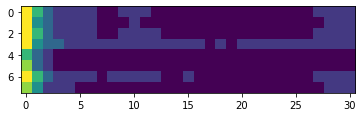

In [19]:
plt.imshow(lowres_hsi_images[1][1])

In [ ]:
# Print the shape of the low-resolution HSI images array
print("Low-Resolution HSI Images Shape:", lowres_hsi_images.shape)

Low-Resolution HSI Images Shape: (2925, 8, 8, 31)


## Obtain A High Resolution RGB Image of Shape (64,64,3)
You'll basically have three 1x1 filters on this image (one will average the bands 1-10, second will average bands 11-20, and the third will average bands 21-31 in the spectral dimensions).

In [7]:
# Apply the 1x1 filters to generate the high-resolution RGB images
highres_rgb_images = np.zeros((groundtruth_arrays.shape[0], 64, 64, 3))
for i in range(groundtruth_arrays.shape[0]):
    for j in range(3):
        start_band = j * 10
        end_band = (j + 1) * 10
        rgb_band_avg = np.mean(groundtruth_arrays[i, :, :, start_band:end_band], axis=-1)
        highres_rgb_images[i, :, :, j] = rgb_band_avg

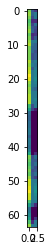

In [23]:
plt.imshow(highres_rgb_images[1][1])

In [9]:
# Print the shape of the high-resolution RGB images array
print("High-Resolution RGB Images Shape:", highres_rgb_images.shape)

High-Resolution RGB Images Shape: (2925, 64, 64, 3)


## Split Images To Form A Test And Train Set

In [10]:
# Split the dataset into training and testing sets
train_ratio = 0.8
num_samples = groundtruth_arrays.shape[0]
num_train_samples = int(train_ratio * num_samples)
train_lowres_hsi = lowres_hsi_images[:num_train_samples]
train_highres_rgb = highres_rgb_images[:num_train_samples]
test_lowres_hsi = lowres_hsi_images[num_train_samples:]
test_highres_rgb = highres_rgb_images[num_train_samples:]

In [11]:
# Normalize the data (optional but recommended)
train_lowres_hsi = train_lowres_hsi / 255.0
train_highres_rgb = train_highres_rgb / 255.0
test_lowres_hsi = test_lowres_hsi / 255.0
test_highres_rgb = test_highres_rgb / 255.0

In [13]:
from keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose, BatchNormalization, Activation, LeakyReLU
from keras.models import Model

def create_super_resolution_model(input_shape_hr, input_shape_lr, output_shape):
    # Define high-resolution input layer
    hr_input = Input(shape=input_shape_hr)

    # Define low-resolution input layer
    lr_input = Input(shape=input_shape_lr)

    # Upsample the low-resolution input
    upsampled_lr = Conv2DTranspose(31, (8, 8), strides=(8, 8), padding='same')(lr_input)

    # Concatenate high-resolution and upsampled low-resolution inputs
    concat = Concatenate()([hr_input, upsampled_lr])

    # Encoder
    x = Conv2D(64, (3, 3), strides=1, padding='same')(concat)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(256, (3, 3), strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(64, (3, 3), strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Conv2D(3, (3, 3), strides=1, padding='same', activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=[hr_input, lr_input], outputs=output)
    return model

# Define input and output shapes
input_shape_hr = (64, 64, 3)
input_shape_lr = (8, 8, 31)
output_shape = (64, 64, 3)

# Create model
model = create_super_resolution_model(input_shape_hr, input_shape_lr, output_shape)

# Print model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8, 8, 31)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 31)  61535       ['input_4[0][0]']                
 ose)                                                                                             
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64, 64, 34)   0           ['input_3[0][0]',          

In [14]:
model.compile(optimizer='adam', loss='mse')  # Compile the model with appropriate optimizer and loss function

model.fit([train_highres_rgb, train_lowres_hsi], train_highres_rgb, validation_data=([test_highres_rgb, test_lowres_hsi], test_highres_rgb), epochs=10, batch_size=32)

Epoch 1/10
74/74 [==============================] - 499s 7s/step - loss: 0.0345 - val_loss: 0.0256
Epoch 2/10
74/74 [==============================] - 343s 5s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 3/10
74/74 [==============================] - 320s 4s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 4/10
74/74 [==============================] - 308s 4s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 5/10
74/74 [==============================] - 311s 4s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 6/10
74/74 [==============================] - 315s 4s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 7/10
74/74 [==============================] - 313s 4s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 8/10
74/74 [==============================] - 300s 4s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 9/10
74/74 [==============================] - 302s 4s/step - loss: 0.0268 - val_loss: 0.0256
Epoch 10/10
74/74 [==============================] - 289s 4s/step - loss: 0.0268 - val_loss: 0.0256
